# Credit Card Default Prediction Version 1

---

**What problem are we trying to solve?**

The goal of this project is to **develop and deploy an ML model** in which an end user can specify a set of features describing billing details and receive a categorical (yes or no) output indicating if the customer defaults to using their credit card.

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, f1_score, precision_recall_curve, precision_score, recall_score

In [6]:
# Store CSV file in variable 
data = r'..\..\data\default_of_credit_card_clients_v2.xls'
# Read CSV file in pandas dataframe 
df = pd.read_excel(data)

In [7]:
# Print dataframe to confirm successful loading
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## Column Meanings 

**LIMIT_BAL**: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

**SEX**: Gender (1 = male; 2 = female).

**EDUCATION**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

**MARRIAGE**: Marital status (1 = married; 2 = single; 3 = others).

**AGE**: Age (year).

**PAY_0** - **PAY_6**: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: *PAY_0* = the repayment status in September, 2005; *PAY_2* = the repayment status in August, 2005; . . .;*PAY_6* = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

**BILL_AMT1** - **BILL_AMT6**: Amount of bill statement (NT dollar). *BILL_AMT1* = amount of bill statement in September, 2005; *BILL_AMT2* = amount of bill statement in August, 2005; . . .; *BILL_AMT6* = amount of bill statement in April, 2005.

**PAY_AMT1** - **PAY_AMT6**: Amount of previous payment (NT dollar). *PAY_AMT1* = amount paid in September, 2005; *PAY_AMT2* = amount paid in August, 2005; . . .;*PAY_AMT6* = amount paid in April, 2005.

### <font color='red'>Target Variable: default_payment_next_month</font>

# Week 1: Data Cleaning and Analysis 

## Data Cleaning

In [12]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()

# Print dataframe to confirm 
df

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [13]:
# Rename old column name to new column name 
df.rename(columns={'pay_0': 'pay_1'}, inplace=True)

# Print dataframe for renamed columns
df

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [14]:
# Create copy of dataframe in case need to use original later 
copy_df = df[['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1',
              'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
              'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
               'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
               'default_payment_next_month']]

In [15]:
# View dataset again 
df

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


### Check columns in correct format with Dtype

In [17]:
# Get summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   id                          30000 non-null  int64
 1   limit_bal                   30000 non-null  int64
 2   sex                         30000 non-null  int64
 3   education                   30000 non-null  int64
 4   marriage                    30000 non-null  int64
 5   age                         30000 non-null  int64
 6   pay_1                       30000 non-null  int64
 7   pay_2                       30000 non-null  int64
 8   pay_3                       30000 non-null  int64
 9   pay_4                       30000 non-null  int64
 10  pay_5                       30000 non-null  int64
 11  pay_6                       30000 non-null  int64
 12  bill_amt1                   30000 non-null  int64
 13  bill_amt2                   30000 non-null  int64
 14  bill_a

### Check for NULL and Duplicate values

In [19]:
# Check for missing values
print(df.isnull().sum())

id                            0
limit_bal                     0
sex                           0
education                     0
marriage                      0
age                           0
pay_1                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt1                     0
bill_amt2                     0
bill_amt3                     0
bill_amt4                     0
bill_amt5                     0
bill_amt6                     0
pay_amt1                      0
pay_amt2                      0
pay_amt3                      0
pay_amt4                      0
pay_amt5                      0
pay_amt6                      0
default_payment_next_month    0
dtype: int64


In [20]:
df.columns

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default_payment_next_month'],
      dtype='object')

In [21]:
# Check for dupicate entries 
df[df.duplicated(subset=['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 
                         'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
                         'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default_payment_next_month'])]

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
1980,1981,150000,2,1,1,38,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
4585,4586,150000,2,1,1,31,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
6022,6023,210000,2,1,2,39,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
6466,6467,210000,2,2,1,49,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
7319,7320,500000,1,1,1,43,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
8320,8321,360000,1,2,1,41,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
10250,10251,50000,1,2,2,26,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
13106,13107,360000,2,1,1,49,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
14294,14295,20000,1,2,2,24,2,2,4,4,...,1650,1650,1650,0,0,0,0,0,0,1
15458,15459,160000,1,2,2,28,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0


Keep the dupicates as this might be data that represents the real-world and see how model performs 

## Exploratory Data Analysis

In [24]:
# View dataset
df

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


### How many used credit cards?

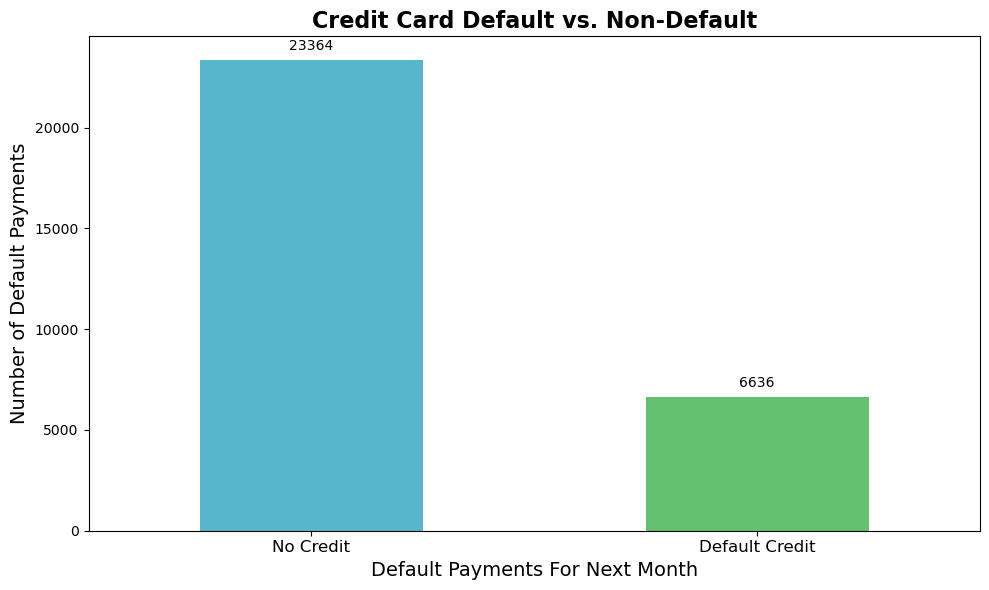

default_payment_next_month
0    77.88
1    22.12
Name: count, dtype: float64


In [26]:
# Count the occurrences of credit card defaulters 
default_counts = df['default_payment_next_month'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
ax = default_counts.plot(kind='bar', color=['#58B6CC','#63C170'])

# Add text annotations
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    
plt.xlabel('Default Payments For Next Month', fontsize=14)
plt.ylabel('Number of Default Payments', fontsize=14)
plt.title('Credit Card Default vs. Non-Default', fontsize=16, fontweight='bold')
plt.xticks(ticks=[0, 1], rotation=0, labels=['No Credit', 'Default Credit'], ha='center', fontsize=12)  # Rotate x-axis labels for better visibility and define labels 
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

print((df['default_payment_next_month'].value_counts()/df.shape[0]) * 100)

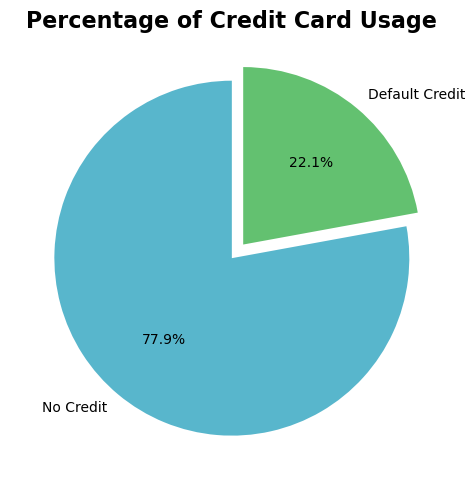

In [27]:
# Visualizing Delayed Flight Percentage

# Extract total number of regular payments and credit card payments
payment, creditCard = df['default_payment_next_month'].value_counts()

# Data and Labels
data = [payment, creditCard]
keys = ['No Credit', 'Default Credit']

# Pie Chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    data,
    labels=keys,
    autopct='%1.1f%%',
    startangle=90,
    explode=[0, 0.1], 
    colors=['#58B6CC','#63C170']
)

# Adjusting Figure Size
fig.set_size_inches(5, 5)

# Title and Layout Adjustments
plt.title('Percentage of Credit Card Usage', fontsize=16, fontweight='bold')
plt.tight_layout()

# Display the plot
plt.show()

The following dataset clearly shows imbalance that we will take care of later. 

### What distribution do we see for the following columns: education, marriage, sex, repayment status?

In [30]:
# Unique categories in "Education"
print("Unique categories in 'Education':", df['education'].unique())

# Unique categories in "Marital Status"
print("Unique categories in 'Marital Status':", df['marriage'].unique())

# Unique categories in "sept_repayment"
print("Unique categories in 'sex':", df['sex'].unique())

# Unique categories in "sept_repayment"
print("Unique categories in 'pay_1':", df['pay_1'].unique())

Unique categories in 'Education': [2 1 3 5 4 6 0]
Unique categories in 'Marital Status': [1 2 3 0]
Unique categories in 'sex': [2 1]
Unique categories in 'pay_1': [ 2 -1  0 -2  1  3  4  8  7  5  6]


*education*: Undocumented values (0, 5, 6)
- 1 = graduate school
- 2 = university
- 3 = high school
- 4 = others

*marriage (Marital Status)*: Undocumented values (0)
- 1 = married
- 2 = single
- 3 = others
  
*sex (Gender)*: No undocumented values
- 1 = male
- 2 = female

*pay_1 - pay_6 (September - April)*: Undocumented values (-2, 0)
- -1 = pay duly
- 1 = payment delay for one month
- 2 = payment delay for two months
-  . . .
-  8 = payment delay for eight months
-  9 = payment delay for nine months and above.

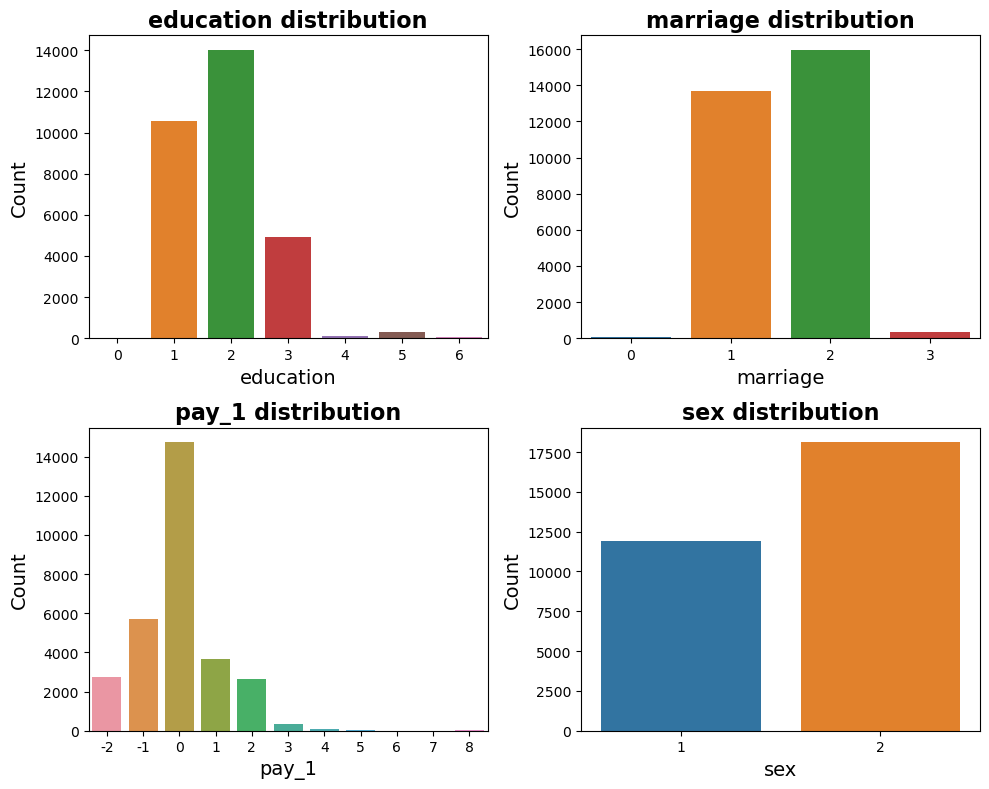

In [32]:
# Visually see how undocumented values are distributed 
columns = ['education', 'marriage', 'pay_1', 'sex']

fig, axes = plt.subplots(nrows=int((len(columns) - 1) / 2) + 1, ncols=2, figsize=(10, 8))

# Flatten axes in case there's only one row
axes = axes.ravel()

for i, col in enumerate(columns):
    try: 
        sns.countplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(f'{col} distribution', fontsize=16, fontweight='bold')
        axes[i].set_xlabel(f'{col}', fontsize=14)
        axes[i].set_ylabel('Count', fontsize=14)
    except IndexError:
        # If all subplots are used, break the loop
        break
        
# Make sure any unused axes don't have titles or labels
#for ax in axes[i:]:
#    ax.axis('off')

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

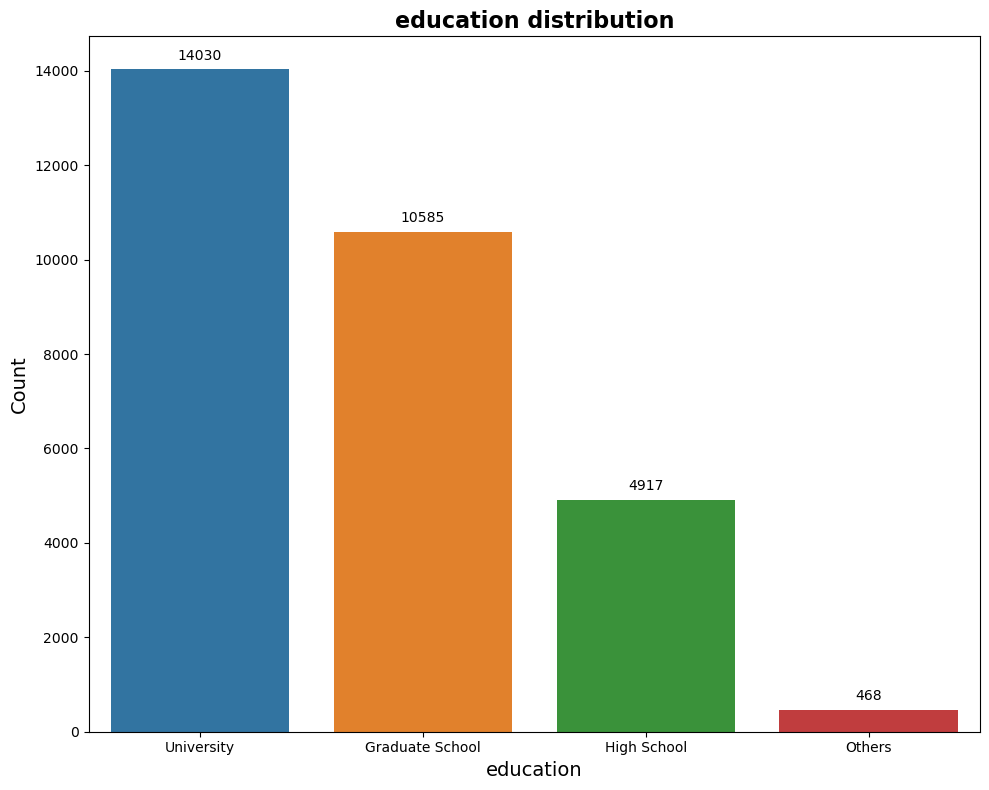

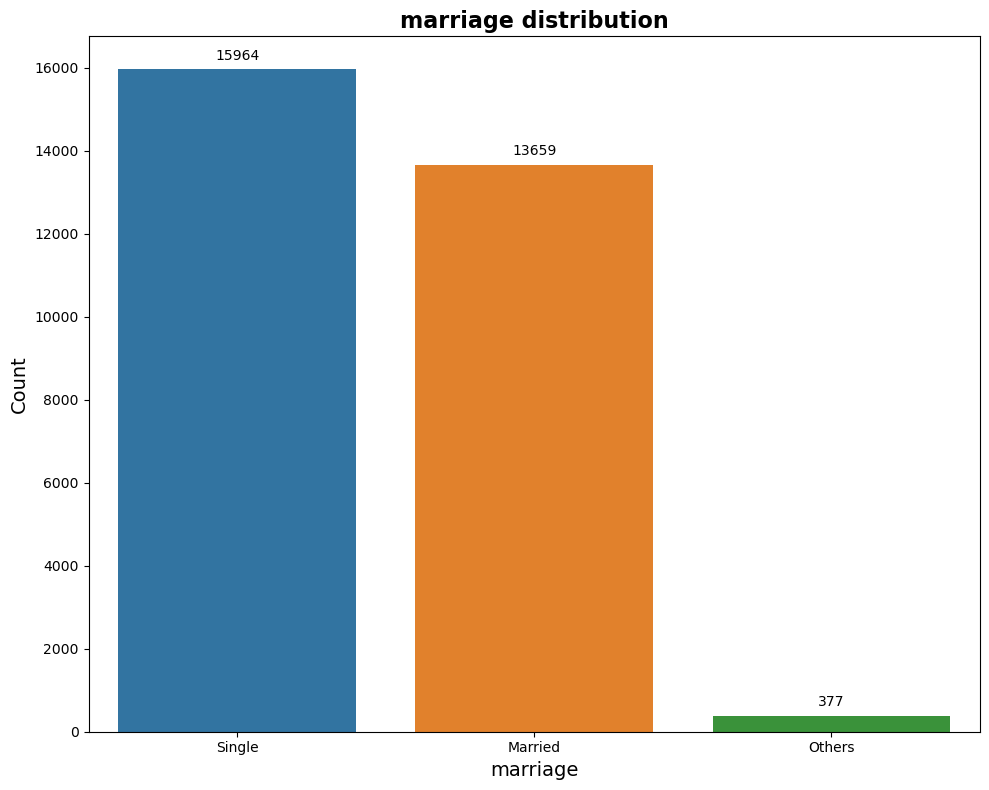

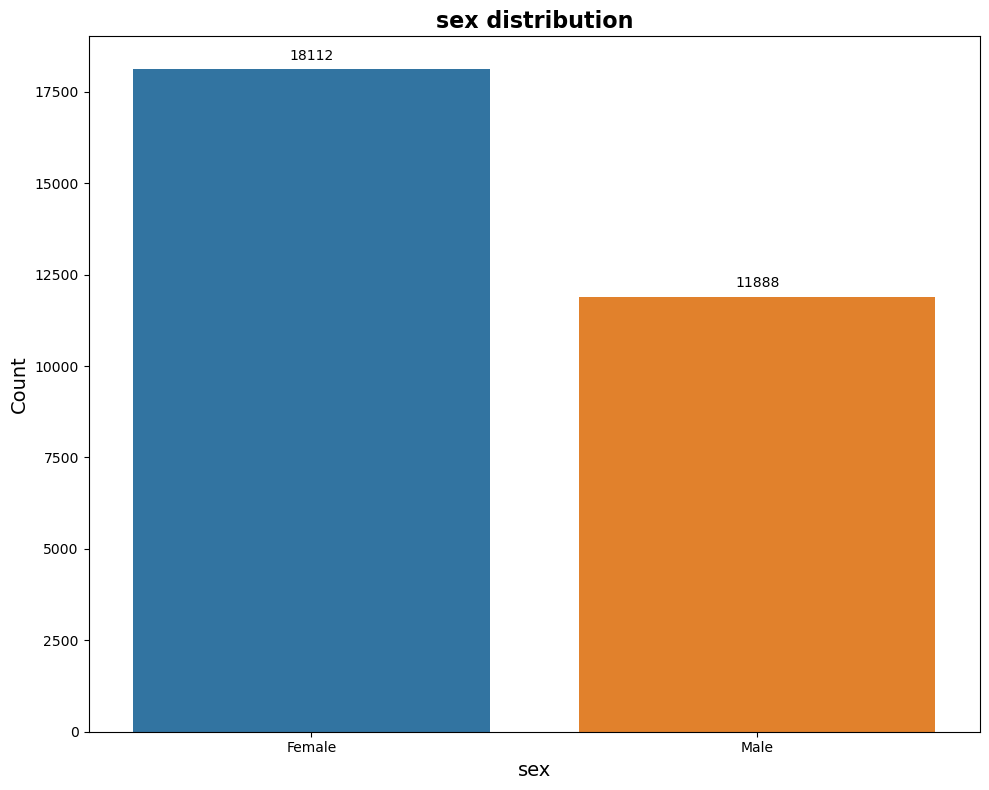

In [33]:
# Define custom labels for each categorical column
labels = {
    'education': {1: 'Graduate School', 2: 'University', 3: 'High School', 4: 'Others'},
    'marriage': {1: 'Married', 2: 'Single', 3: 'Others'},
    'sex': {1: 'Male', 2: 'Female'}
}

# Combine undocumented values under one 
fil = (df['education'] == 5) | (df['education'] == 6) | (df['education'] == 0)
df.loc[fil, 'education'] = 4
fil = df['marriage'] == 0
df.loc[fil, 'marriage'] = 3

for column in labels:
    # Create a copy of the column with mapped values
    df[f'{column}_labeled'] = df[column].map(labels[column])

    plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
    order = df[f'{column}_labeled'].value_counts().index
    ax = sns.countplot(data=df, x=f'{column}_labeled', order=order)
    # Add text annotations
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    plt.title(f'{column} distribution', fontsize=16, fontweight='bold')
    plt.xlabel(f'{column}', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(ha='center', rotation=0)
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

In [34]:
# Percentage of distribution 
print(round((df['education_labeled'].value_counts()/df.shape[0]) * 100,2))
print('\n')
print(round((df['marriage_labeled'].value_counts()/df.shape[0]) * 100,2))
print('\n')
print(round((df['sex_labeled'].value_counts()/df.shape[0]) * 100,2))

education_labeled
University         46.77
Graduate School    35.28
High School        16.39
Others              1.56
Name: count, dtype: float64


marriage_labeled
Single     53.21
Married    45.53
Others      1.26
Name: count, dtype: float64


sex_labeled
Female    60.37
Male      39.63
Name: count, dtype: float64


In [35]:
# Percentage of distribution 
print(round((df['education'].value_counts()/df.shape[0]) * 100,2))
print('\n')
print(round((df['marriage'].value_counts()/df.shape[0]) * 100,2))
print('\n')
print(round((df['sex'].value_counts()/df.shape[0]) * 100,2))

education
2    46.77
1    35.28
3    16.39
4     1.56
Name: count, dtype: float64


marriage
2    53.21
1    45.53
3     1.26
Name: count, dtype: float64


sex
2    60.37
1    39.63
Name: count, dtype: float64


### How is age distributed?

C:\Users\ohins\anaconda3\envs\Python3_12_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


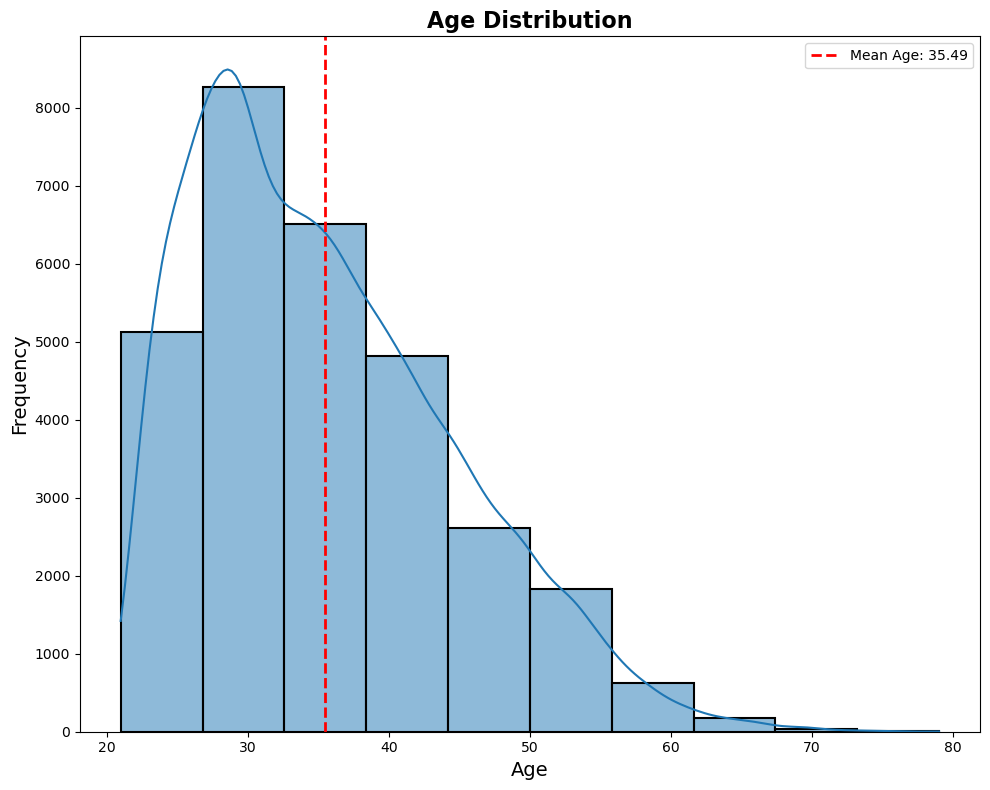

In [37]:
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
ax = sns.histplot(data=df, x='age', bins=10, kde=True, edgecolor='black', linewidth=1.5)

# Calculate and plot the mean
mean_age = df['age'].mean()
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean Age: {mean_age:.2f}')

plt.title('Age Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(ha='center', rotation=0)
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

**Key Observations**
1. Age Distribution
   - The age distribution appears to be a right-tailed distribution, with most being around 25 - 40 years of age
2. Mean Age
   - The mean age is 35.49, which is indicated by the dotted red line
   - This acts as a reference point to understand where the central tendency of ages lie in relation to overall distribution
   - The mean age is closer to the younger age range and might be skewed towards the younger folks
3. KDE (Kernel Density Estimate)
   - The light blue KDE line represnets a smoothed estimate for the distribution, giving the overall shape to the age distribution that is easier to interpret than the raw histogram
   - The KDE suggests a right-tailed distribution that has a high peak around the age of 30

### How is the limit balance distributed? 

C:\Users\ohins\anaconda3\envs\Python3_12_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


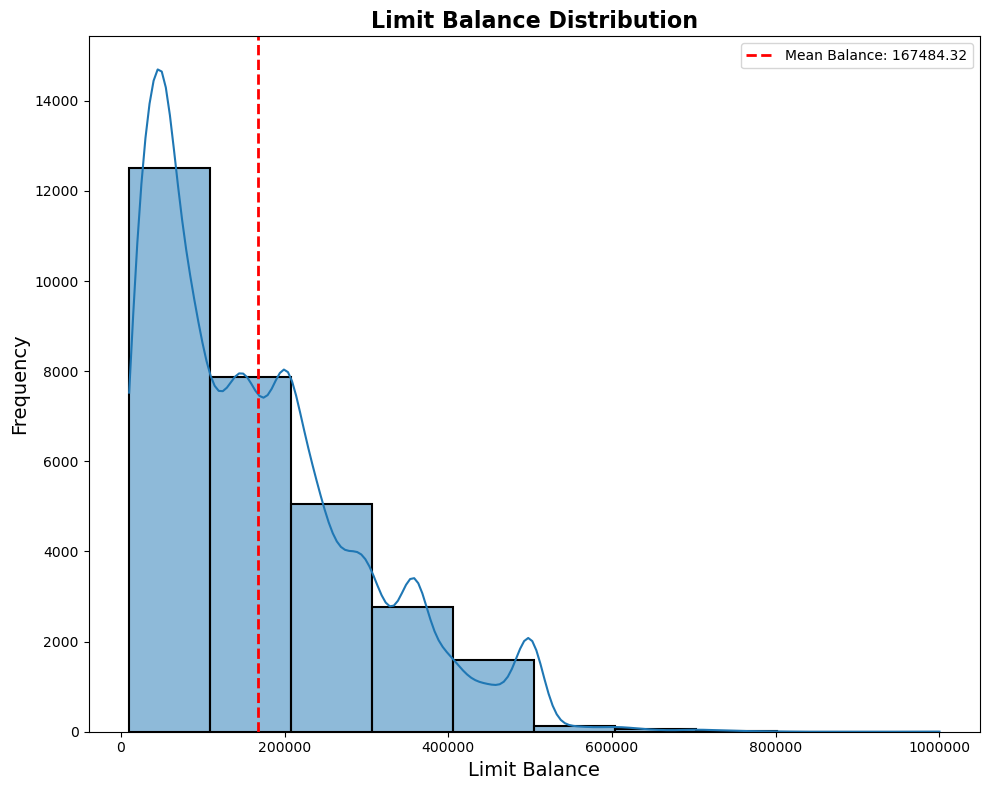

In [40]:
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
ax = sns.histplot(data=df, x='limit_bal', bins=10, kde=True, edgecolor='black', linewidth=1.5)

# Calculate and plot the mean
mean_bal = df['limit_bal'].mean()
plt.axvline(mean_bal, color='red', linestyle='dashed', linewidth=2, label=f'Mean Balance: {mean_bal:.2f}')

plt.title('Limit Balance Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Limit Balance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(ha='center', rotation=0)
# Format the x-axis tick labels
plt.ticklabel_format(style='plain', axis='x')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

**Key Observations**

1. Credit Limit Distribution
   - It seems like most of the dataset consists of having a lower credit limit (below 200,000)
2. Mean Credit Limit
   - The mean credit limit is 167,484.32, which is indicated by the dotted red line
   - The mean credit limit is closer to the lower range
3. KDE (Kernel Density Estimate)
   - The blue line gives a smoothed estimate for the distribution
   - The highest peak is around 100,000 with little bumpy peaks around 200,000

### Repayment Status

In [43]:
# Create a base DataFrame
base_df = copy_df[['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'default_payment_next_month']]

# Melt payment status columns
payment_status_cols = ['id'] + [col for col in copy_df.columns if col.startswith('pay_')]
payment_status_df = pd.melt(copy_df[payment_status_cols], id_vars=['id'], var_name='month', value_name='payment_status')
month_mapping = {'pay_1': 'September', 'pay_2': 'August', 'pay_3': 'July', 'pay_4': 'June', 'pay_5': 'May', 'pay_6': 'April'}
payment_status_df['month'] = payment_status_df['month'].map(month_mapping)

# Melt bill amount columns
bill_amount_cols = ['id'] + [col for col in copy_df.columns if col.startswith('bill_amt')]
bill_amount_df = pd.melt(copy_df[bill_amount_cols], id_vars=['id'], var_name='month', value_name='bill_amt')
month_mapping_bill = {'bill_amt1': 'September', 'bill_amt2': 'August', 'bill_amt3': 'July', 'bill_amt4': 'June', 'bill_amt5': 'May', 'bill_amt6': 'April'}
bill_amount_df['month'] = bill_amount_df['month'].map(month_mapping_bill)

# Melt payment amount columns
payment_amount_cols = ['id'] + [col for col in copy_df.columns if col.startswith('pay_amt')]
payment_amount_df = pd.melt(copy_df[payment_amount_cols], id_vars=['id'], var_name='month', value_name='payment_amt')
month_mapping_pay = {'pay_amt1': 'September', 'pay_amt2': 'August', 'pay_amt3': 'July', 'pay_amt4': 'June', 'pay_amt5': 'May', 'pay_amt6': 'April'}
payment_amount_df['month'] = payment_amount_df['month'].map(month_mapping_pay)

# Merge DataFrames
merged_df = pd.merge(payment_status_df, bill_amount_df, on=['id', 'month'], how='outer')
merged_df = pd.merge(merged_df, payment_amount_df, on=['id', 'month'], how='outer')

# Merge with base DataFrame
final_df = pd.merge(base_df, merged_df, on=['id'], how='outer')

In [44]:
# View dataset
final_df

,id,limit_bal,sex,education,marriage,age,default_payment_next_month,month,payment_status,bill_amt,payment_amt
0,1,20000,2,2,1,24,1,September,2,3913.0,0.0
1,1,20000,2,2,1,24,1,August,2,3102.0,689.0
2,1,20000,2,2,1,24,1,July,-1,689.0,0.0
3,1,20000,2,2,1,24,1,June,-1,0.0,0.0
4,1,20000,2,2,1,24,1,May,-2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
359995,30000,50000,1,2,1,46,1,NaN,1800,NaN,NaN
359996,30000,50000,1,2,1,46,1,NaN,1430,NaN,NaN
359997,30000,50000,1,2,1,46,1,NaN,1000,NaN,NaN
359998,30000,50000,1,2,1,46,1,NaN,1000,NaN,NaN


In [45]:
# Drop NaN values 
# These values repeat ID number, but since there are only 6 months of data, it tries to find additional months data, which isn't there
final_df.dropna(inplace=True)

In [46]:
# Drop unnecessary columns 
final_df.drop(['id'], axis=1, inplace=True)

In [47]:
# View dataset
final_df

,limit_bal,sex,education,marriage,age,default_payment_next_month,month,payment_status,bill_amt,payment_amt
0,20000,2,2,1,24,1,September,2,3913.0,0.0
1,20000,2,2,1,24,1,August,2,3102.0,689.0
2,20000,2,2,1,24,1,July,-1,689.0,0.0
3,20000,2,2,1,24,1,June,-1,0.0,0.0
4,20000,2,2,1,24,1,May,-2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
359989,50000,1,2,1,46,1,August,0,48905.0,1800.0
359990,50000,1,2,1,46,1,July,0,49764.0,1430.0
359991,50000,1,2,1,46,1,June,0,36535.0,1000.0
359992,50000,1,2,1,46,1,May,0,32428.0,1000.0


In [48]:
# Grouping numerical columns and
# Moving the target variable to be the right-most column

# Columns to move
cols_to_move = [
                'limit_bal', 
                'sex', 
                'education', 
                'marriage', 
                'age',
                'month', 
                'payment_status',
                'bill_amt', 
                'payment_amt'
                ]

last_col = 'default_payment_next_month'

# Extracting the columns to move
columns_to_move = final_df[cols_to_move]

# Dropping these columns from the DataFrame
final_df.drop(columns=cols_to_move, inplace=True)

# Extracting the last column
last_column = final_df.pop(last_col)

# Reinserting the numerical columns
final_df = pd.concat([final_df, columns_to_move], axis=1)

# Reinserting the last column
final_df[last_col] = last_column

In [49]:
# View dataset after moving columns around 
final_df

,limit_bal,sex,education,marriage,age,month,payment_status,bill_amt,payment_amt,default_payment_next_month
0,20000,2,2,1,24,September,2,3913.0,0.0,1
1,20000,2,2,1,24,August,2,3102.0,689.0,1
2,20000,2,2,1,24,July,-1,689.0,0.0,1
3,20000,2,2,1,24,June,-1,0.0,0.0,1
4,20000,2,2,1,24,May,-2,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
359989,50000,1,2,1,46,August,0,48905.0,1800.0,1
359990,50000,1,2,1,46,July,0,49764.0,1430.0,1
359991,50000,1,2,1,46,June,0,36535.0,1000.0,1
359992,50000,1,2,1,46,May,0,32428.0,1000.0,1


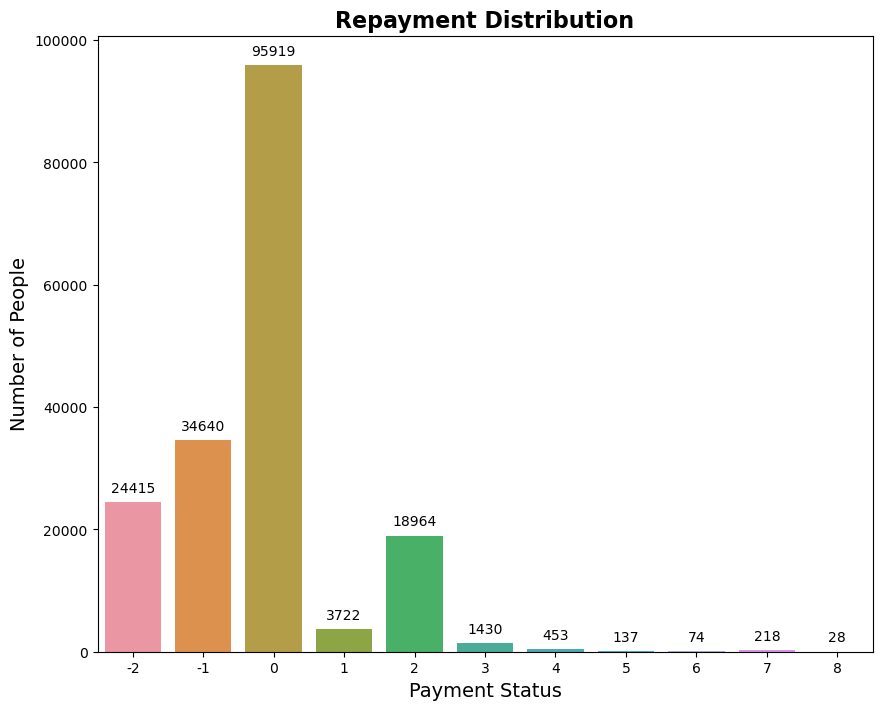

payment_status
 0    53.29
-1    19.24
-2    13.56
 2    10.54
 1     2.07
 3     0.79
 4     0.25
 7     0.12
 5     0.08
 6     0.04
 8     0.02
Name: count, dtype: float64


In [50]:
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability

ax = sns.countplot(final_df, x='payment_status')

# Add text annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.xlabel('Payment Status', fontsize=14)
plt.ylabel('Number of People', fontsize=14)
plt.title('Repayment Distribution', fontsize=16, fontweight='bold')
plt.show()

# Percentage of distribution 
print(round((final_df['payment_status'].value_counts()/final_df.shape[0]) * 100,2))

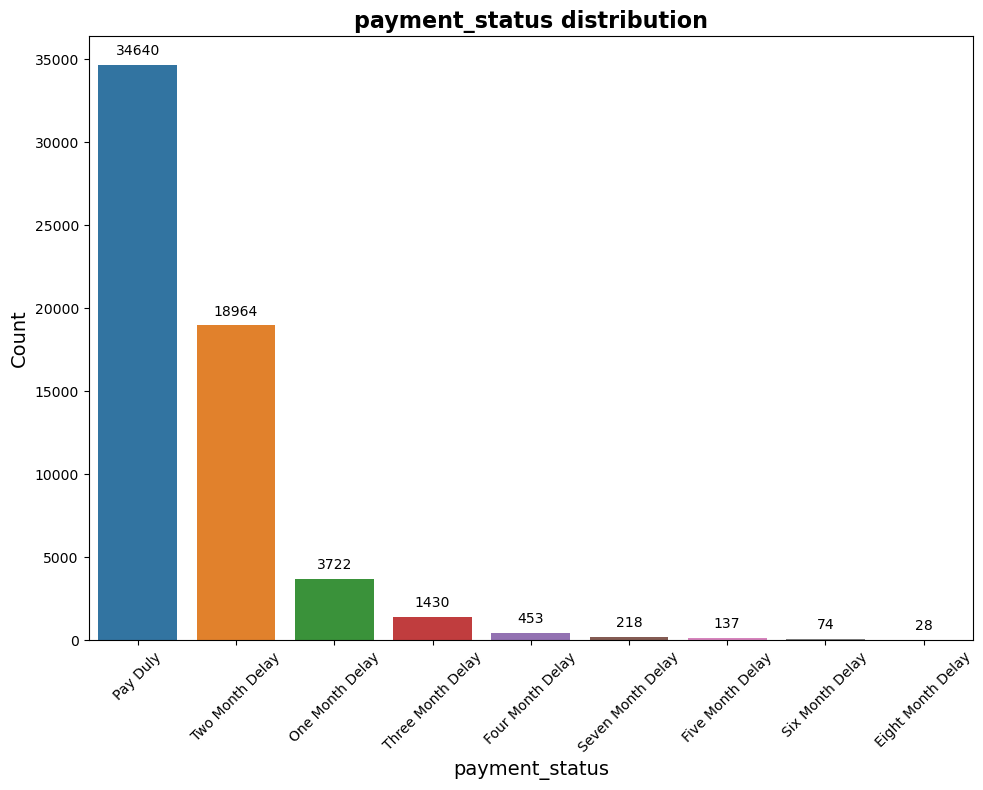

In [51]:
# Define custom labels for each categorical column
labels = {
    'payment_status': {-1: 'Pay Duly', 1: 'One Month Delay', 2: 'Two Month Delay', 3: 'Three Month Delay', 4: 'Four Month Delay',
                      5: 'Five Month Delay', 6: 'Six Month Delay', 7: 'Seven Month Delay', 8: 'Eight Month Delay'}
}

for column in labels:
    # Create a copy of the column with mapped values
    final_df[f'{column}_labeled'] = final_df[column].map(labels[column])

    plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
    order = final_df[f'{column}_labeled'].value_counts().index
    ax = sns.countplot(data=final_df, x=f'{column}_labeled', order=order)
    # Add text annotations
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    plt.title(f'{column} distribution', fontsize=16, fontweight='bold')
    plt.xlabel(f'{column}', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(ha='center', rotation=45)
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

In [52]:
# Percentage of distribution 
print(round((final_df['payment_status_labeled'].value_counts()/final_df.shape[0]) * 100,2))

payment_status_labeled
Pay Duly             19.24
Two Month Delay      10.54
One Month Delay       2.07
Three Month Delay     0.79
Four Month Delay      0.25
Seven Month Delay     0.12
Five Month Delay      0.08
Six Month Delay       0.04
Eight Month Delay     0.02
Name: count, dtype: float64


### Outlier Analysis

In [54]:
# Set the default display format for floats
pd.options.display.float_format = '{:.2f}'.format

# Calculate descriptive statistics for bill_amt
final_df.groupby('month')['bill_amt'].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
April,30000.00,38871.76,59554.11,-339603.00,1256.00,17071.00,49198.25,961664.00
August,30000.00,49179.08,71173.77,-69777.00,2984.75,21200.00,64006.25,983931.00
July,30000.00,47013.15,69349.39,-157264.00,2666.25,20088.50,60164.75,1664089.00
June,30000.00,43262.95,64332.86,-170000.00,2326.75,19052.00,54506.00,891586.00
May,30000.00,40311.40,60797.16,-81334.00,1763.00,18104.50,50190.50,927171.00
September,30000.00,51223.33,73635.86,-165580.00,3558.75,22381.50,67091.00,964511.00


In [55]:
# Calculate descriptive statistics for payment_amt
final_df.groupby('month')['payment_amt'].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
April,30000.00,5215.50,17777.47,0.00,117.75,1500.00,4000.00,528666.00
August,30000.00,5921.16,23040.87,0.00,833.00,2009.00,5000.00,1684259.00
July,30000.00,5225.68,17606.96,0.00,390.00,1800.00,4505.00,896040.00
June,30000.00,4826.08,15666.16,0.00,296.00,1500.00,4013.25,621000.00
May,30000.00,4799.39,15278.31,0.00,252.50,1500.00,4031.50,426529.00
September,30000.00,5663.58,16563.28,0.00,1000.00,2100.00,5006.00,873552.00


<Figure size 800x600 with 0 Axes>

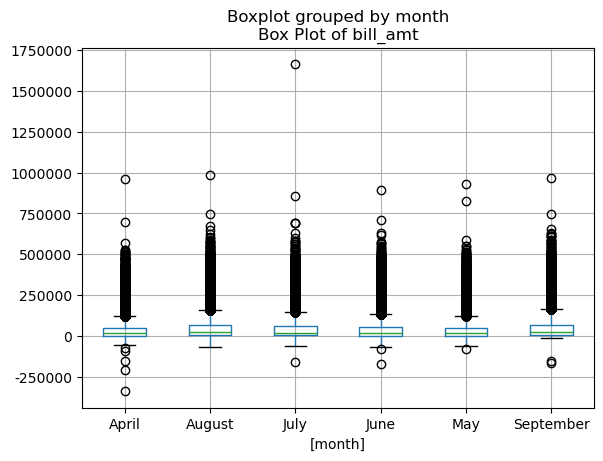

<Figure size 800x600 with 0 Axes>

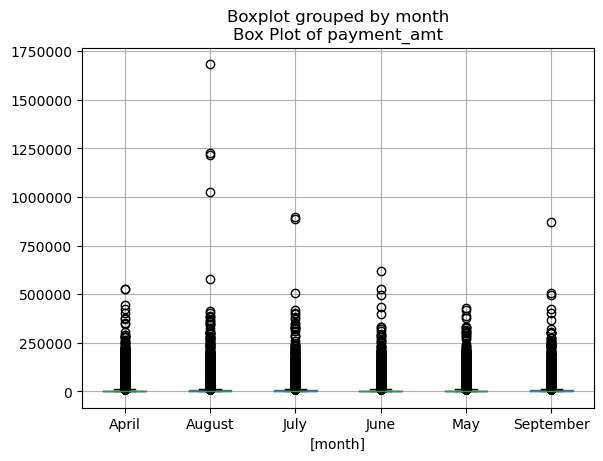

In [56]:
num_features = ['bill_amt', 'payment_amt']

for feature in num_features:
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    final_df[['month', feature]].boxplot(by='month')
    plt.title(f"Box Plot of {feature}")
    # Format y-axis labels
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    plt.show()

In [57]:
def detect_outliers(data):
    """Identifies outliers using the Interquartile Range (IQR) method.

    Args:
        data: A pandas Series containing the data.

    Returns:
        A pandas Series with 1 for outliers and 0 for non-outliers.
    """
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers.astype(int)

# Identify outliers in 'bill_amt' and 'payment_amt'
final_df['bill_amt_outlier'] = detect_outliers(final_df['bill_amt'])
final_df['payment_amt_outlier'] = detect_outliers(final_df['payment_amt'])

In [58]:
# Group data by months and calculate number of outliers for each month 
outlier_counts = final_df.groupby('month')[['bill_amt_outlier', 'payment_amt_outlier']].sum()
outlier_counts = outlier_counts.rename(columns={'bill_amt_outlier': 'bill_amt_outliers', 'payment_amt_outlier': 'payment_amt_outliers'})

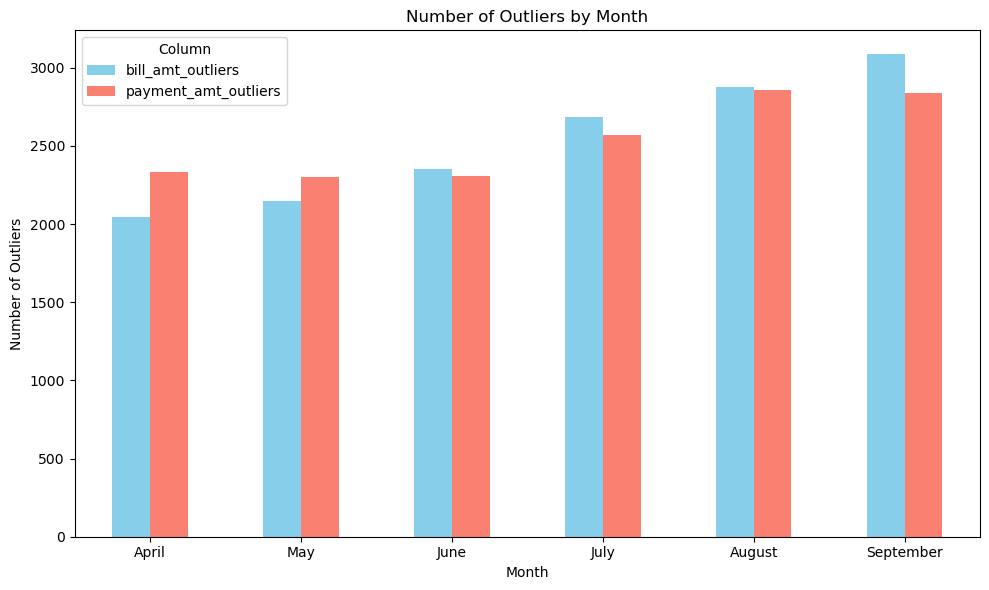

In [59]:
# Visualize number of outliers 

# Create a month order dictionary for sorting
month_order = {
    'April': 1, 'May': 2, 'June': 3,
    'July': 4, 'August': 5, 'September': 6
}

# Sort the index using the month order
outlier_counts = outlier_counts.reindex(sorted(outlier_counts.index, 
                                             key=lambda x: month_order[x]))

# Create a bar chart
ax = outlier_counts.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])

# Customize the chart
plt.title('Number of Outliers by Month')
plt.xlabel('Month')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Column')
plt.tight_layout()
plt.show()

In [60]:
# View a summary of outliers in the dataset 
outlier_counts

,bill_amt_outliers,payment_amt_outliers
month,,
April,2043,2332
May,2149,2303
June,2352,2305
July,2685,2567
August,2874,2859
September,3085,2836


There are significnat outliers in our dataset, but in this scenario, this might be an indicator of the real world. Thus, outliers will not be removed from bill_amt and payment_amt columns. 

Let's look for any outliers in the limit_bal column (these do not need to be broken down by month since credit limit is consistent across months) 

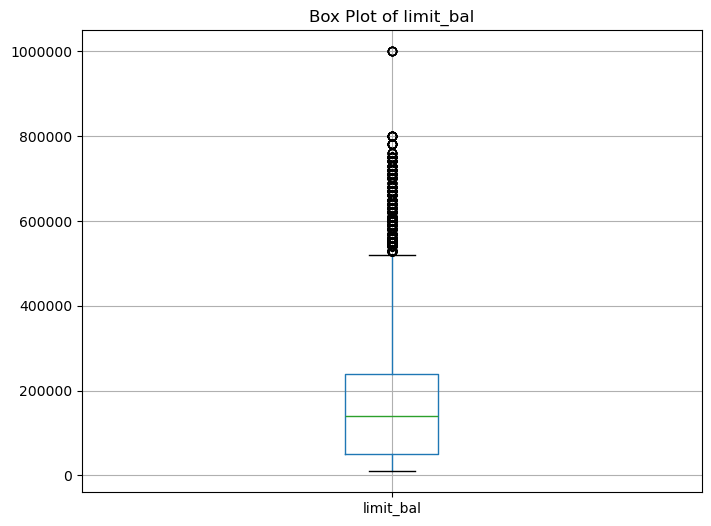

In [62]:
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
final_df[['limit_bal']].boxplot()
plt.title(f"Box Plot of limit_bal")
# Format y-axis labels
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.show()

In [63]:
# Identify outliers in 'limit_bal'
final_df['limit_bal_outlier'] = detect_outliers(final_df['limit_bal'])

In [64]:
# Calculate number of outliers in credit limit column 
outlier_counts = final_df[['limit_bal_outlier']].sum()

In [65]:
# View a summary of outliers in the dataset 
outlier_counts

limit_bal_outlier    1002
dtype: int64

There are few outliers in Limit Balance columns, but will not remove and leave as is 

### Relationships with target variable (default_payment_next_month)

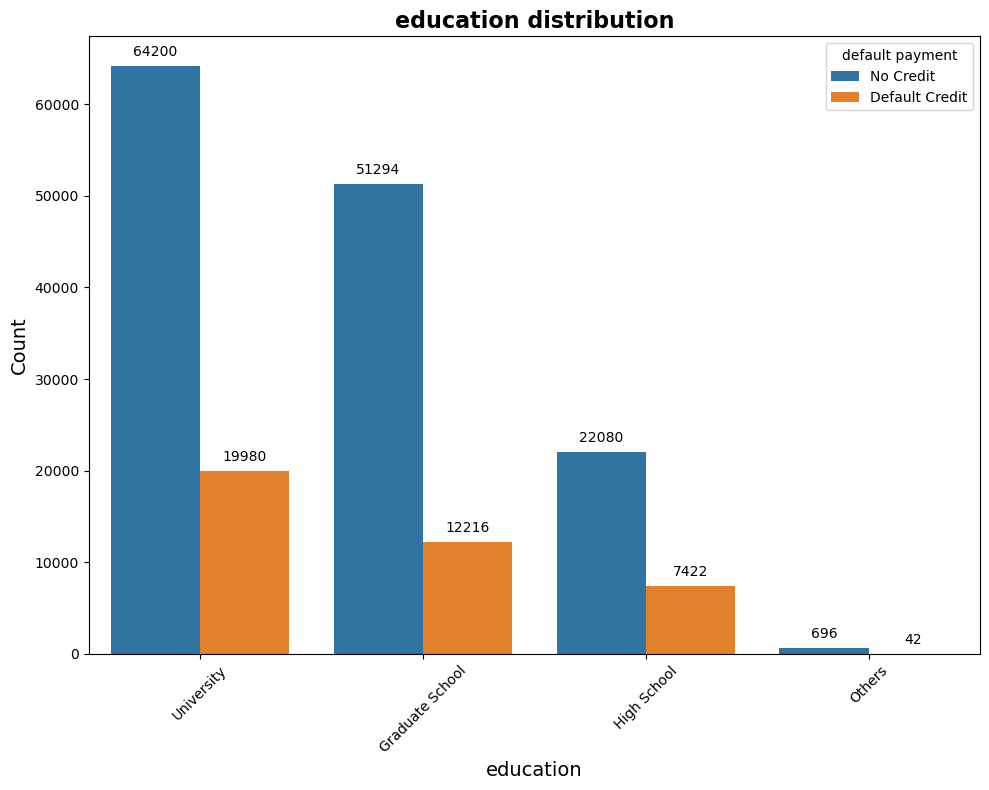

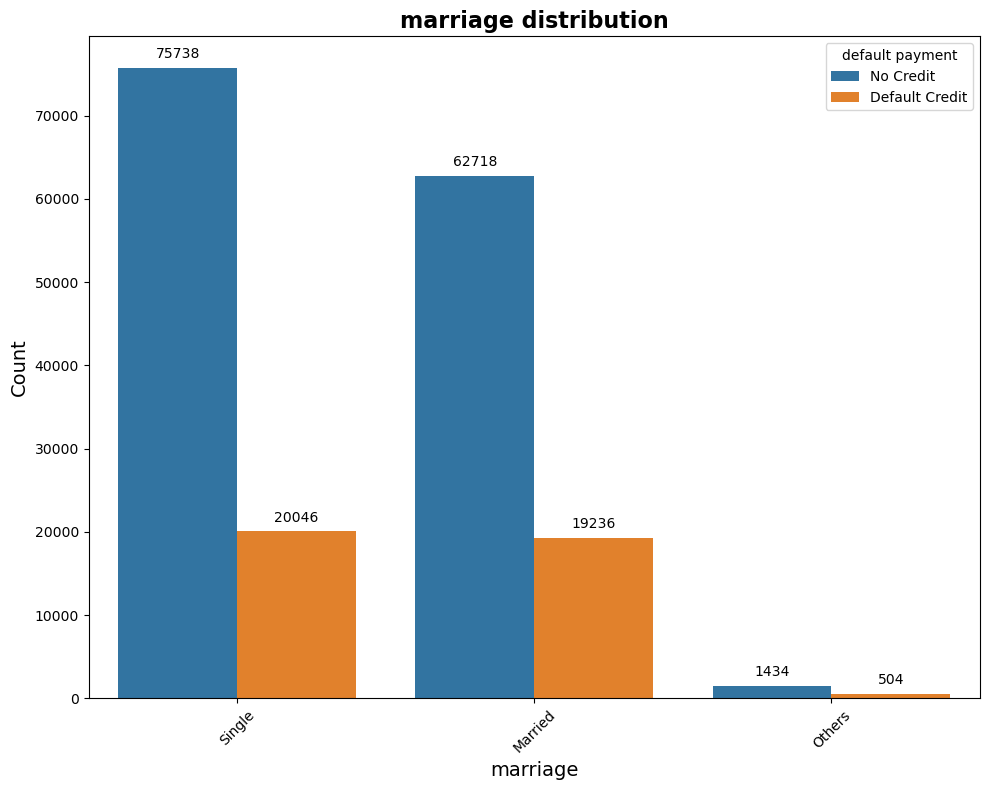

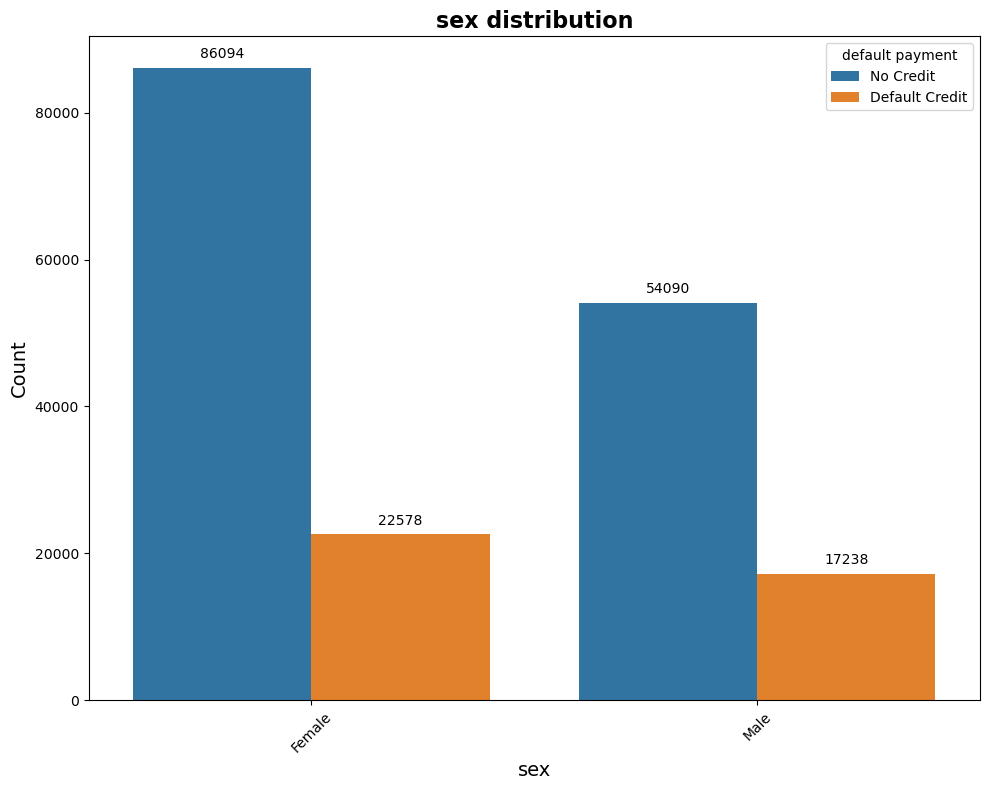

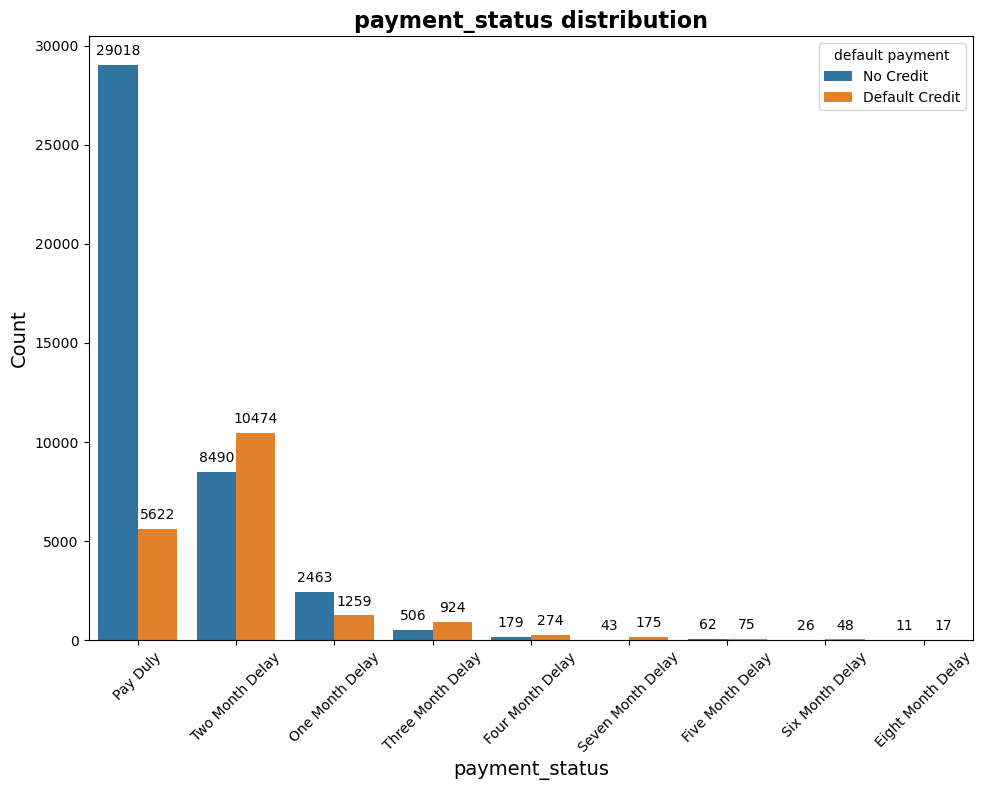

In [68]:
# Define custom labels for each categorical column
labels = {
    'education': {1: 'Graduate School', 2: 'University', 3: 'High School', 4: 'Others'},
    'marriage': {1: 'Married', 2: 'Single', 3: 'Others'},
    'sex': {1: 'Male', 2: 'Female'}, 
    'payment_status': {-1: 'Pay Duly', 1: 'One Month Delay', 2: 'Two Month Delay', 3: 'Three Month Delay', 4: 'Four Month Delay',
                      5: 'Five Month Delay', 6: 'Six Month Delay', 7: 'Seven Month Delay', 8: 'Eight Month Delay'}
}

for column in labels:
    # Create a copy of the column with mapped values
    final_df[f'{column}_labeled'] = final_df[column].map(labels[column])

    plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
    order = final_df[f'{column}_labeled'].value_counts().index
    ax = sns.countplot(data=final_df, x=f'{column}_labeled', order=order, hue='default_payment_next_month')
    # Add text annotations
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    plt.title(f'{column} distribution', fontsize=16, fontweight='bold')
    plt.xlabel(f'{column}', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(ha='center', rotation=45)
    plt.legend(title='default payment', labels=['No Credit', 'Default Credit'])
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

**Key Observations**

Education 
- Graduate and University show the likelihood of defaulting to credit cards

Marriage
- Single and Married show about the same for defaulting to a credit card

Sex
- Females are more likley to default to a credit care than Males

Payment Status 
- Pay Duly and Two Month Delay show significant numbers when defaulting to a credit card 

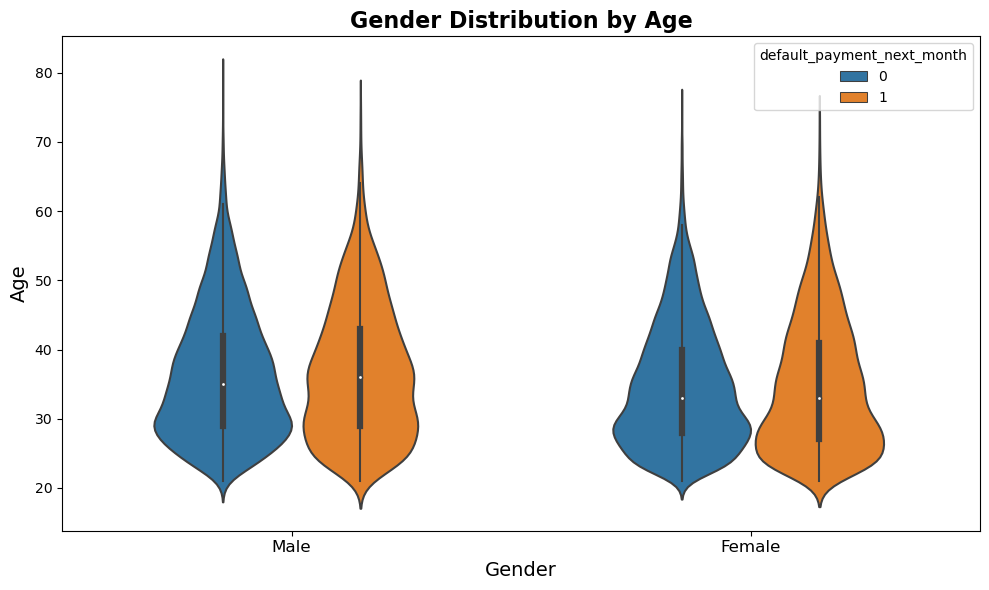

In [70]:
# Create a violin plot for Gender by Age
plt.figure(figsize=(10, 6))  # Adjust the size of the figure
sns.violinplot(data=df, x='sex', y='age', hue='default_payment_next_month', width=0.6)

# Add title and labels with improved formatting
plt.title('Gender Distribution by Age', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Age', fontsize=14)

# Show tick labels
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'], fontsize=12, ha='center', rotation=0)  # Rotate y-axis labels for better visibility and define labels 
plt.tight_layout()
plt.show()

### Remove Columns to Avoid Any Biases and Imbalance

In [72]:
# This column isn't relevant to what we are doing 
df.drop(['id'], axis=1, inplace=True)

print('Columns remaining: ', df.shape[1])

Columns remaining:  27


In [73]:
# View dataset
df

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,education_labeled,marriage_labeled,sex_labeled
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,689,0,0,0,0,1,University,Married,Female
1,120000,2,2,2,26,-1,2,0,0,0,...,0,1000,1000,1000,0,2000,1,University,Single,Female
2,90000,2,2,2,34,0,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,University,Single,Female
3,50000,2,2,1,37,0,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,University,Married,Female
4,50000,1,2,1,57,-1,0,-1,0,0,...,2000,36681,10000,9000,689,679,0,University,Married,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,8500,20000,5003,3047,5000,1000,0,High School,Married,Male
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,1837,3526,8998,129,0,0,0,High School,Single,Male
29997,30000,1,2,2,37,4,3,2,-1,0,...,0,0,22000,4200,2000,3100,1,University,Single,Male
29998,80000,1,3,1,41,1,-1,0,0,0,...,85900,3409,1178,1926,52964,1804,1,High School,Married,Male


## Feature Selection

In [75]:
# Drop unnecessary columns 
df.drop(['education_labeled', 'marriage_labeled', 'sex_labeled'], axis=1, inplace=True)

In [76]:
# View dataset
df

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


**Correlation Analysis**

Highly correlated features with default_payment_next_month above 20.0%:
['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5']


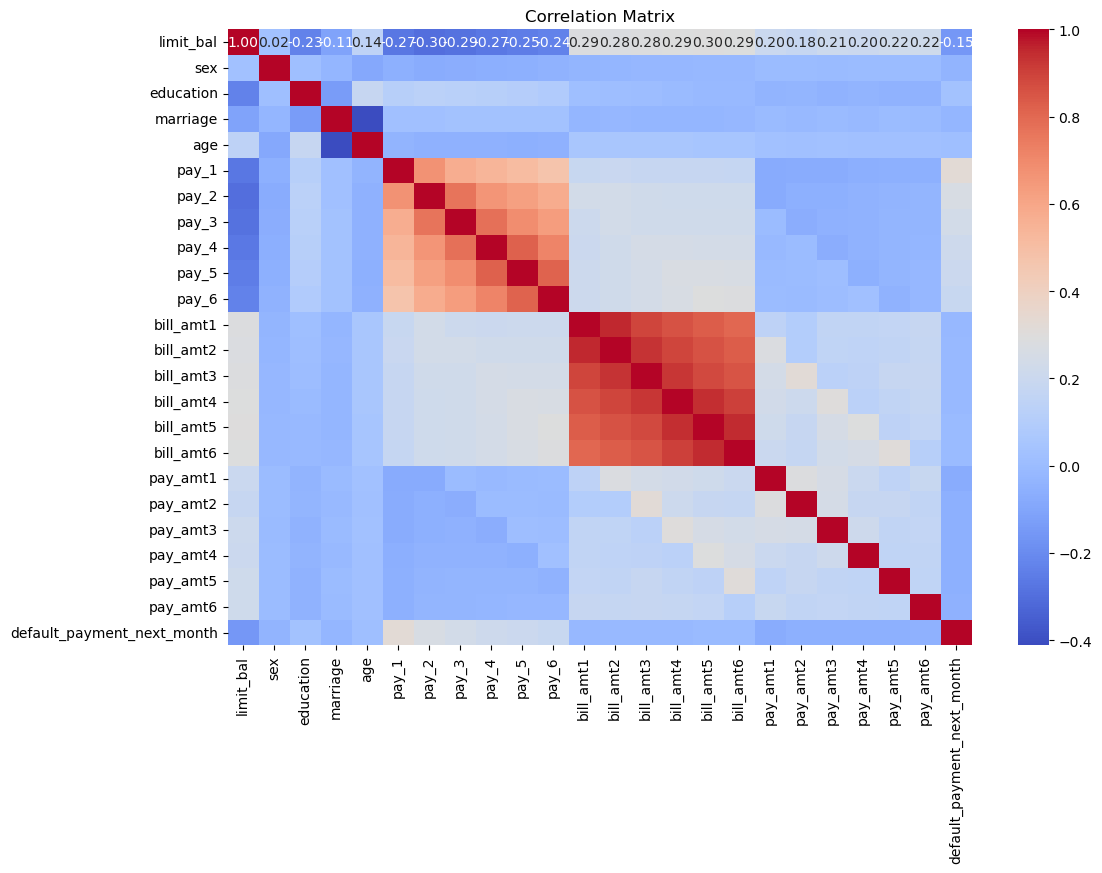

default_payment_next_month    1.00
pay_1                         0.32
pay_2                         0.26
pay_3                         0.24
pay_4                         0.22
pay_5                         0.20
pay_6                         0.19
education                     0.03
age                           0.01
bill_amt6                    -0.01
bill_amt5                    -0.01
bill_amt4                    -0.01
bill_amt3                    -0.01
bill_amt2                    -0.01
bill_amt1                    -0.02
marriage                     -0.03
sex                          -0.04
pay_amt6                     -0.05
pay_amt5                     -0.06
pay_amt3                     -0.06
pay_amt4                     -0.06
pay_amt2                     -0.06
pay_amt1                     -0.07
limit_bal                    -0.15
Name: default_payment_next_month, dtype: float64


In [78]:
corr_matrix = df.corr()

# Select the target variable correlation
target_variable = 'default_payment_next_month'  
correlations = corr_matrix[target_variable]

# Retrieve features with correlation above the threshold
threshold = 0.2
highly_correlated_features = correlations[correlations > threshold].index.tolist()

# Remove the target variable itself from the list
if target_variable in highly_correlated_features:
    highly_correlated_features.remove(target_variable)

print(f'Highly correlated features with {target_variable} above {threshold*100}%:')
print(highly_correlated_features)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

# Get correlations with the target variable
target_correlation = corr_matrix['default_payment_next_month'].sort_values(ascending=False)
# Print the values
print(target_correlation)

## Using SMOTE to take care of our imbalanced dataset (as seen earlier through EDA) 

In [80]:
# Oversample dataset so it becomes balanced 
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(df.iloc[:,0:-1], df['default_payment_next_month'])

print('Original dataset shape', len(df))
print('Resampled dataset shape', len(y_smote))

Original dataset shape 30000
Resampled dataset shape 46728


In [81]:
# View new dataset 
x_smote

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46723,483697,1,1,1,37,0,-1,-1,-1,-1,...,1485,2828,522,33388,7628,1491,2833,592,33478,100
46724,80000,1,2,1,29,2,2,0,0,0,...,25918,26773,29652,30815,992,1826,1379,3341,1793,321
46725,230000,2,1,2,30,0,1,-1,-1,0,...,2340,2189,1949,1911,34,2340,2189,1689,1911,225
46726,110000,2,1,1,37,0,2,1,0,0,...,3104,3204,5314,5627,2583,442,1468,3368,404,0


In [82]:
columns = list(df.columns)

In [83]:
columns.pop()

'default_payment_next_month'

In [84]:
balance_df = pd.DataFrame(x_smote, columns=columns)

In [85]:
balance_df['default_payment_next_month'] = y_smote

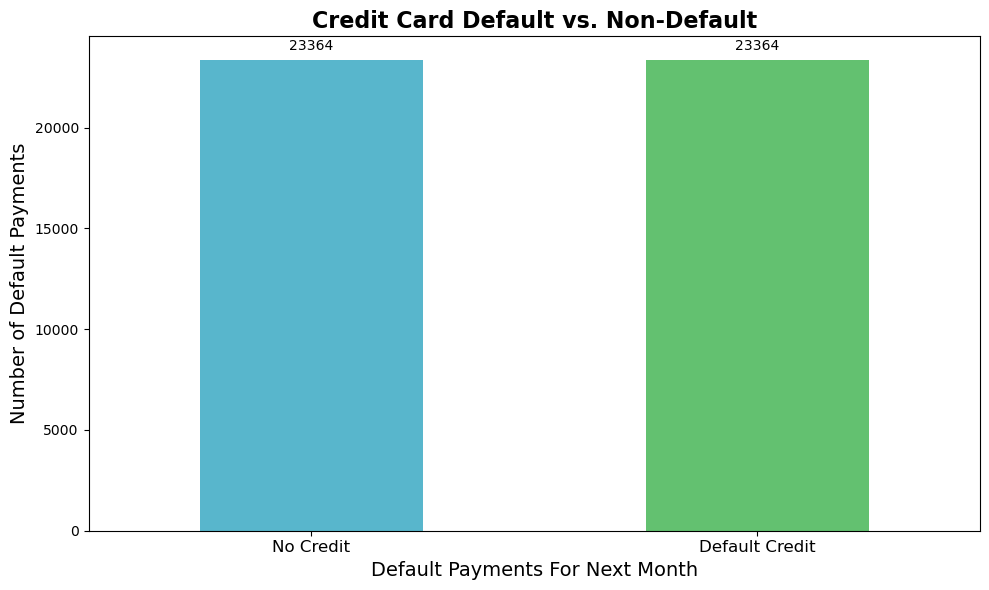

default_payment_next_month
1   50.00
0   50.00
Name: count, dtype: float64


In [86]:
# Count the occurrences of credit card defaulters 
default_counts = balance_df['default_payment_next_month'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
ax = default_counts.plot(kind='bar', color=['#58B6CC','#63C170'])

# Add text annotations
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    
plt.xlabel('Default Payments For Next Month', fontsize=14)
plt.ylabel('Number of Default Payments', fontsize=14)
plt.title('Credit Card Default vs. Non-Default', fontsize=16, fontweight='bold')
plt.xticks(ticks=[0, 1], rotation=0, labels=['No Credit', 'Default Credit'], ha='center', fontsize=12)  # Rotate x-axis labels for better visibility and define labels 
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

print((balance_df['default_payment_next_month'].value_counts()/balance_df.shape[0]) * 100)

## Week 2 & 3: Feature Engineering and Model Selection

### Feature Engineering

Now that we have resampled the dataset, let's build new features 

In [90]:
# View dataset with new features 
df

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


### Model Selection

Recall the correlation matrix. Let's use these columns for model selection 

Highly correlated features with default_payment_next_month above 20.0%:

'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'

In [93]:
# Define categorical and numerical features
categorical_features = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

# Define X (features) and y (target) variables
X = balance_df[categorical_features]
y = balance_df["default_payment_next_month"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"x_train shape: {X_train.shape}")
print(f"x_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (37382, 6)
x_test shape: (9346, 6)
y_train shape: (37382,)
y_test shape: (9346,)


### Model Selection

In [95]:
# Define the models
models = {
    'logreg': LogisticRegression(random_state=42, solver='lbfgs', max_iter=200),
    'svm': LinearSVC(random_state=42),
    'gradient_boosted_classifier': GradientBoostingClassifier(random_state=42),
    'random_forest_classifier': RandomForestClassifier(random_state=42),
    'xgboost': XGBClassifier(random_state=42),
    'lightgbm': LGBMClassifier(random_state=42), 
    'catboost': CatBoostClassifier(random_state=42)
}

def model_train(models):
    # Dictionary to hold the results
    results = {
        'model': [],
        'accuracy': [],
        'precision': [],
        'recall': [], 
        'f1': [], 
        'roc-auc': [], 
        'training_time': []
    }

    # Iterate over the models
    for name, model in models.items():
        train_start = datetime.now()
        model.fit(X_train, y_train)
        train_stop = datetime.now()
        train_time = train_stop - train_start

        y_pred = model.predict(X_test)
        
        # Calculate precision and recall
        precision, recall, _ = precision_recall_curve(y_test, y_pred)

        # Calculate ROC AUC score
        roc_auc = roc_auc_score(y_test, y_pred)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Collect the results
        results['model'].append(name)
        results['accuracy'].append(accuracy)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['roc-auc'].append(roc_auc)
        results['training_time'].append(train_time.total_seconds())  # Convert to seconds for easier readability

    return results
    
results = model_train(models)

[LightGBM] [Info] Number of positive: 18682, number of negative: 18700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499759 -> initscore=-0.000963
[LightGBM] [Info] Start training from score -0.000963
Learning rate set to 0.048357
0:	learn: 0.6759999	total: 207ms	remaining: 3m 26s
1:	learn: 0.6612084	total: 227ms	remaining: 1m 53s
2:	learn: 0.6506764	total: 238ms	remaining: 1m 19s
3:	learn: 0.6388071	total: 247ms	remaining: 1m 1s
4:	learn: 0.6286071	total: 257ms	remaining: 51.2s
5:	learn: 0.6214800	total: 265ms	remaining: 44s
6:	learn: 0.6143021	total: 274ms	remaining: 38.8s
7:	learn: 0.6079036	total: 282ms	remaining: 35s
8:	learn: 0.6030

In [96]:
# Convert the results to a DataFrame
results_df = pd.DataFrame(results).set_index('model')

# Display the DataFrame
results_df

,accuracy,precision,recall,f1,roc-auc,training_time
model,,,,,,
logreg,0.68,"[0.500962978814466, 0.7475044039929536, 1.0]","[1.0, 0.5437847073900043, 0.0]",0.63,0.68,0.03
svm,0.68,"[0.500962978814466, 0.7695939565627951, 1.0]","[1.0, 0.5222127296027339, 0.0]",0.62,0.68,0.03
gradient_boosted_classifier,0.73,"[0.500962978814466, 0.8246772740918643, 1.0]","[1.0, 0.5867150790260572, 0.0]",0.69,0.73,1.24
random_forest_classifier,0.74,"[0.500962978814466, 0.8238736102984201, 1.0]","[1.0, 0.6014523707817172, 0.0]",0.70,0.74,1.15
xgboost,0.74,"[0.500962978814466, 0.8292174947932163, 1.0]","[1.0, 0.5952584365655703, 0.0]",0.69,0.74,0.55
lightgbm,0.73,"[0.500962978814466, 0.8265671641791045, 1.0]","[1.0, 0.5914139256727894, 0.0]",0.69,0.73,1.01
catboost,0.73,"[0.500962978814466, 0.824360105913504, 1.0]","[1.0, 0.5984621956428876, 0.0]",0.69,0.74,8.80


**Key Observations**

- **Gradient Boosting Classifier**, **Random Forest Classifier**, **XGBoost**, **LightGBM**, and **CatBoost** had the highest accuracy out of all the models, meaning that these models predicted **73 - 74%** of the instances
- **Random Forest Classifier** had the highest F1 score of **70%** while the other models had a score of **69%**
- All models had the highest ROC-AUC score of **73 - 74%**. This indicates these models are somewhat capable of distinguishing between the two classes, but there is room for improvement

Is there a way to improve model accuracy, F1, and ROC-AUC scores? 

### Model Creation

## Week 4: Deployment